# 1. Feature Engineering

In [1]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images


Q1 – How many positives samples are in positive_patches?


In [2]:
print(positive_patches.shape[0])

13233


Q2 – Show some positive samples (e.g., 16) (plt.subplot() and plt.imhsow())


In [3]:
import matplotlib.pyplot as plt

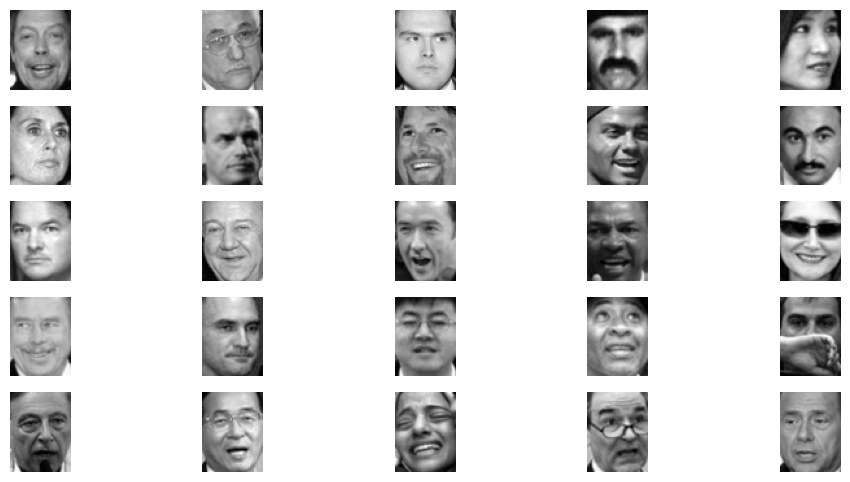

In [4]:
plt.figure(figsize=(12, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1 )
    plt.imshow(faces.images[i], cmap = 'gray')
    plt.axis("off")
plt.show()

Q3 – Try the Scikit-Image’s HOG extractor and visualize the oriented gradients for a given 
sample

In [7]:
from skimage import feature
import skimage.data
img = faces.images[0]
hog_vec, hog_vis = feature.hog(img, visualize=True)

In [8]:
from skimage import data, transform, color
from sklearn.feature_extraction.image import PatchExtractor
import numpy as np
def convert_to_gray_or_keep(img):
    if img.ndim == 3 and img.shape[-1] == 3:
        # If it's an RGB image, convert to grayscale
        return color.rgb2gray(img)
    else:
        # If it's already grayscale or has a different number of channels, keep it as is
        return img
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
images = [convert_to_gray_or_keep(getattr(data, name)()) for name in imgs_to_use]
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
 max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                for patch in patches])
    return patches
negative_patches = np.vstack([extract_patches(im, 1000, scale)
 for im in images for scale in [0.5, 1.0, 2.0]])

Q4 – How many negative samples are in negative_patches?

In [9]:
print(negative_patches.shape[0])

30000


Q5 – Show some negative samples (e.g., 16) (plt.subplot() and plt.imhsow())

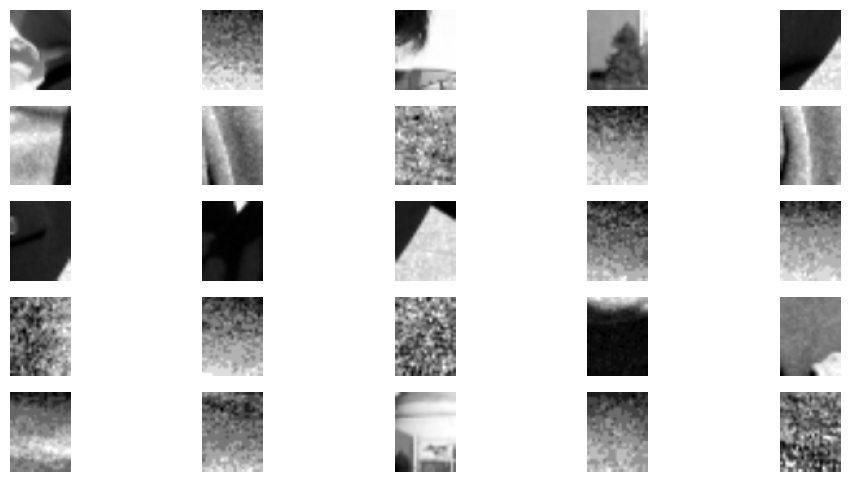

In [10]:
plt.figure(figsize=(12, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1 )
    plt.imshow(negative_patches[i], cmap = 'gray')
    plt.axis("off")
plt.show()

Q6 – Combine negative and positive sets (same number of samples in each set) and extract their 
HOG features to get data set X of size [n_samples, n_features].

In [11]:
M= positive_patches.shape[0]
X= []
for i in range(M):
    hog_vec = feature.hog(positive_patches[i]).reshape((1,-1)) 
    if i==0:
        X = hog_vec
    else:
        X= np.vstack((X,hog_vec))
        
Y= np.ones((M,1))


for i in range(M):
    hog_vec = feature.hog(negative_patches[i]).reshape((1,-1)) 
    X = np.vstack((X,hog_vec))
        
Y= np.vstack((Y,np.zeros((M,1))))

Q7 – Construct vector of labels y: 0 for all negative samples and 1 for all positive samples.


In [12]:
print(Y)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


# 2. Binary Classification using Scikit-Learn

(21172, 1215) (5294, 1215) (21172,) (5294,)
KNeighborsClassifier()
{'n_neighbors': 5}
DecisionTreeClassifier()
{'max_depth': 90}
RandomForestClassifier()
{'n_estimators': 80}
      Estimator  Accuracy
0    KNeighbors  0.995655
1  DecisionTree  0.937854
2            RF  0.990555


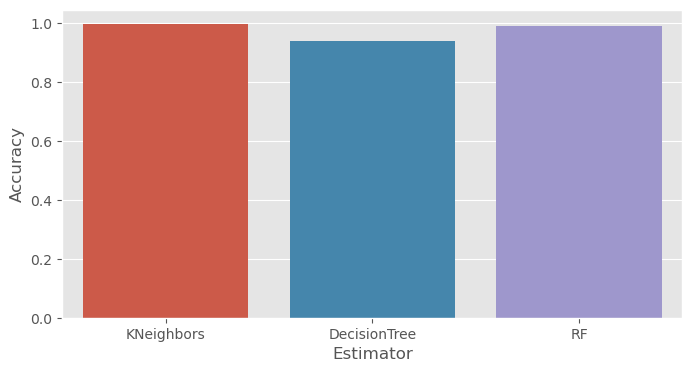

In [23]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
Y = Y.ravel() 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# View the shape of the data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

models = [
 { "estimater": KNeighborsClassifier(),
 "params": {
 "n_neighbors": [5,7,9],
 }
 },
 { "estimater": DecisionTreeClassifier(),
 "params": {
 "max_depth": [90,100],
 }
 },
 
 { "estimater": RandomForestClassifier(),
 "params": {
 "n_estimators": [80, 90, 100],
 }
 }
]
column_names = ["KNeighbors", "DecisionTree", "RF"]
entries = []
max_acc = 0
best_model = None
for model in models:
    print(model["estimater"])
 # Create model
    clf = model["estimater"]
 # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = clf, param_grid = model["params"], 
 cv = 5)
 
 # Fit the model
    grid_search.fit(X_train, y_train);
 # Make predictions on the test set compute accuracy metric
    predicted = grid_search.predict(X_test)
    acc = accuracy_score(predicted, y_test)
    entries.append(acc)
    print(grid_search.best_params_)
 # Get the best model with the highest accuracy
    if acc > max_acc:
        max_acc = acc
        best_model = grid_search

plt.style.use('ggplot')
df = pd.DataFrame({"Estimator": column_names, "Accuracy": entries})
plt.figure(figsize=(8, 4))
sns.barplot(x='Estimator', y='Accuracy', data=df)
print(df)


Q8 – Test the above scripts and write in a markdown cell your conclusions.

We used three different classifiers for our task: K-Nearest Neighbors (KNN), Decision Tree, and Random Forest. These classifiers have different characteristics and are suitable for various types of problems.

In the model evaluation the results are :
    -It seems that both the K-Nearest Neighbors (KNN) and Random Forest (RF) models have achieved similar high accuracy levels        of approximately 95.95%, while the Decision Tree model achieved a slightly lower accuracy of 92.57%.

In conclusion, based solely on accuracy, the KNN and RF models appear to perform better on the given dataset compared to the Decision Tree model.

3. Evaluating the Best Face Detector


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_preds(y_true, y_preds):
 
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                  "precision": round(precision, 2),
                  "recall": round(recall, 2),
                  "f1": round(f1, 2)}
 
    return metric_dict

Q9- Make predictions using the test data to see how the best model performs by applying the 
evaluate_preds function.


In [25]:
y_preds = best_model.predict(X_test) 
evaluation_results = evaluate_preds(y_test, y_preds)
print("Evaluation results:")
print(evaluation_results)

Evaluation results:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


# 4. Finding Faces in a New Image


Q10- Get a new test image by executing this script:


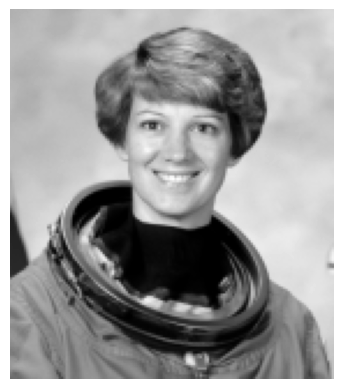

In [26]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')
plt.axis('off');


Q11- Create a window that iterates over patches of this image, and compute HOG features for 
each patch:


In [27]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])

Q12- Use our face detector to evaluate whether each patch contains a face. What do you notice?


In [28]:
labels = grid_search.predict(patches_hog)
labels.sum()

69.0

Q13- Draw face detected patches as rectangles:


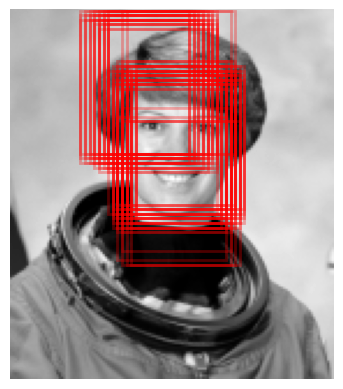

In [29]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', 
alpha=0.3, lw=2, facecolor='none'))
